<a href="https://colab.research.google.com/github/bismillahkani/ISL-CV-Team3/blob/master/Video_Classification_using_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aim: To classify videos using Keras

Datasets: https://www.crcv.ucf.edu/data/UCF_YouTube_Action.php

### Load packages and libraries

In [1]:
import numpy as np
import pandas as pd
import glob
import cv2
import math    
from PIL import Image
import tensorflow as tf
import keras
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
from keras.models import Model
from keras.models import Sequential
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,AveragePooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Conv3D, MaxPool3D, MaxPooling3D, GlobalMaxPool2D, GlobalMaxPool3D, AveragePooling3D
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet_v2 import ResNet152V2
from keras import regularizers
from keras.optimizers import SGD, RMSprop
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.utils import np_utils, generic_utils
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

Using TensorFlow backend.


### Dataset Exploration

### Load dataset

In [0]:
import os
import zipfile

local_zip = '/content/drive/My Drive/ISL Video/dataset_11.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

In [0]:
dataset_path = '/tmp/dataset_11/'
video_paths=[video_path for video_path in glob.glob(dataset_path+'/*/*')]
video_categories=[os.path.basename(os.path.dirname(video_path)) for video_path in video_paths]
filenames=[os.path.basename(video_path) for video_path in video_paths]

In [4]:
dataset_df = pd.DataFrame({'video_paths':video_paths,'filename':filenames,'video_category':video_categories})
dataset_df.sort_values('video_category',inplace=True)
dataset_df.head()

,video_paths,filename,video_category
986,/tmp/dataset_11/biking/v_biking_02_06.mpg,v_biking_02_06.mpg,biking
969,/tmp/dataset_11/biking/v_biking_16_05.mpg,v_biking_16_05.mpg,biking
970,/tmp/dataset_11/biking/v_biking_15_05.mpg,v_biking_15_05.mpg,biking
971,/tmp/dataset_11/biking/v_biking_09_03.mpg,v_biking_09_03.mpg,biking
972,/tmp/dataset_11/biking/v_biking_06_03.mpg,v_biking_06_03.mpg,biking


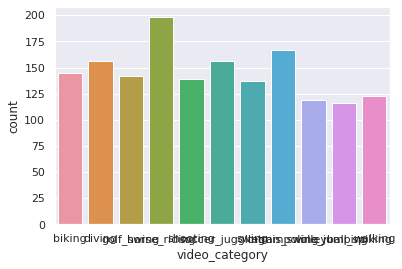

In [5]:
sns.set(style="darkgrid")
ax = sns.countplot(x="video_category", data=dataset_df)

Helper functions

In [0]:
# Helper function to plot learning curves

def plot_training(history):
    fig = plt.figure(figsize=(16,4))
    ax = fig.add_subplot(121)
    ax.plot(history.history["val_loss"], label="val_loss")
    ax.plot(history.history["loss"], label="train_loss")
    ax.set_title("validation/training loss")
    ax.set_xlabel("epochs")
    ax.legend()

    ax2 = fig.add_subplot(122)
    ax2.plot(history.history["val_acc"], label="val_acc")
    ax2.plot(history.history["acc"], label="train_acc")
    ax2.set_title("validation/training accuracy")
    ax2.set_xlabel("epochs")
    ax2.set_ylim(0, 1)
    ax2.legend()

    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Keras Video Generator

In [7]:
! pip install keras-video-generators

In [0]:
from keras_video import VideoFrameGenerator
from keras_video import utils as ku

In [0]:
# some global params
channels = 3
input_size = (64,64)
input_dims = (64, 64, 3)
input_shape = (15, 64, 64, 3)
n_frames = 15
batch_size = 2
classes = list(dataset_df['video_category'].unique())
n_classes = len(classes)

In [0]:
# pattern to get videos and classes
glob_pattern='/tmp/dataset/{classname}/*'

In [13]:
# for data augmentation
data_aug = ImageDataGenerator(
    zoom_range=.1,
    horizontal_flip=True,
    rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2)

# Create video frame generator
train_generator = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=n_frames,
    split_val=0.2, 
    shuffle=True,
    batch_size=batch_size,
    target_shape=input_size,
    nb_channel=channels,
    transformation=data_aug,
    use_frame_cache=True)

val_generator = train_generator.get_validation_generator()

class biking, validation count: 29, train count: 116
class diving, validation count: 31, train count: 125
class golf_swing, validation count: 0, train count: 0
class horse_riding, validation count: 0, train count: 0
class shooting, validation count: 28, train count: 113
class soccer_juggling, validation count: 0, train count: 0
class swing, validation count: 0, train count: 0
class tennis_swing, validation count: 0, train count: 0
class trampoline_jumping, validation count: 0, train count: 0
class volleyball_spiking, validation count: 0, train count: 0
class walking, validation count: 0, train count: 0
Total data: 11 classes for 354 files for train
Total data: 11 classes for 88 files for validation


Model callbacks

In [0]:
def scheduler(epoch):
  if epoch < 3:
    return 0.001
  else:
    return 0.001 * 1/(1 + 0.0001 * epoch)

learning_rate_scheduler = LearningRateScheduler(scheduler)

earlystopping = EarlyStopping(monitor='acc', mode='max', patience=5, verbose=1)

checkpoint = ModelCheckpoint('/content/drive/My Drive/ISL Video/isl_3DCNN_v1.hdf5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

callbacks = [learning_rate_scheduler, earlystopping, checkpoint]

# Custom 3DCNN model

In [0]:
def build_convnet3D(input_shape=(15, 16, 16, 3),n_classes=3):
    momentum = .9
    model = keras.Sequential()
    model.add(Conv3D(16, (3,3,3), input_shape=input_shape, padding='same', activation='relu'))
    model.add(Conv3D(16, (3,3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))    
    model.add(MaxPool3D())    
    model.add(Conv3D(32, (3,3,3), padding='same', activation='relu'))
    model.add(Conv3D(32, (3,3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))    
    model.add(MaxPool3D())  
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    return model

In [21]:
model = build_convnet3D(input_shape, n_classes)
model.summary()



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 15, 64, 64, 16)    1312      
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 15, 64, 64, 16)    6928      
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 64, 64, 16)    64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 32, 32, 16)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 7, 32, 32, 32)     13856     
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 7, 32, 32, 32)     27680     
___

In [25]:
# sgd = optimizers.SGD(lr=0.0001)
adam = optimizers.Adam(lr=0.001)

#model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics=['accuracy'])

classweight = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

history = model.fit_generator(train_generator, 
                              steps_per_epoch = (train_generator.files_count // train_generator.batch_size), 
                              epochs = 50, 
                              validation_data = val_generator, 
                              validation_steps = (val_generator.files_count // val_generator.batch_size),
                              class_weight=classweight,
                              verbose = 1, 
                              callbacks=callbacks)

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_24_01.mpg, 1 total, 1 extracted


Epoch 1/50


Frame count is not OK for video /tmp/dataset/shooting/v_shooting_25_06.mpg, 12 total, 12 extracted


24/44 [===============>..............] - ETA: 3s - loss: 10.1817 - acc: 0.3683

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_16_05.mpg, 13 total, 13 extracted


44/44 [==============================] - 8s 186ms/step - loss: 10.7674 - acc: 0.3320 - val_loss: 10.7454 - val_acc: 0.3333


Frame count is not OK for video /tmp/dataset/shooting/v_shooting_24_01.mpg, 1 total, 1 extracted


Epoch 2/50
28/44 [==================>...........] - ETA: 2s - loss: 10.9373 - acc: 0.3214

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_25_06.mpg, 12 total, 12 extracted


43/44 [============================>.] - ETA: 0s - loss: 10.7566 - acc: 0.3326

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_16_05.mpg, 13 total, 13 extracted


44/44 [==============================] - 7s 153ms/step - loss: 10.7738 - acc: 0.3316 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 3/50
 1/44 [..............................] - ETA: 4s - loss: 10.0738 - acc: 0.3750

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_24_01.mpg, 1 total, 1 extracted


 8/44 [====>.........................] - ETA: 4s - loss: 11.5849 - acc: 0.2812

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_25_06.mpg, 12 total, 12 extracted


33/44 [=====================>........] - ETA: 1s - loss: 10.7367 - acc: 0.3339

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_16_05.mpg, 13 total, 13 extracted


44/44 [==============================] - 7s 154ms/step - loss: 10.8452 - acc: 0.3271 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 4/50
 1/44 [..............................] - ETA: 4s - loss: 14.1033 - acc: 0.1250

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_24_01.mpg, 1 total, 1 extracted


28/44 [==================>...........] - ETA: 2s - loss: 10.8653 - acc: 0.3259

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_25_06.mpg, 12 total, 12 extracted


38/44 [========================>.....] - ETA: 0s - loss: 10.7025 - acc: 0.3360

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_16_05.mpg, 13 total, 13 extracted


44/44 [==============================] - 7s 153ms/step - loss: 10.7472 - acc: 0.3332 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 5/50
 1/44 [..............................] - ETA: 4s - loss: 16.1181 - acc: 0.0000e+00

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_24_01.mpg, 1 total, 1 extracted


26/44 [================>.............] - ETA: 2s - loss: 11.3137 - acc: 0.2981

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_16_05.mpg, 13 total, 13 extracted


35/44 [======================>.......] - ETA: 1s - loss: 10.9702 - acc: 0.3194

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_25_06.mpg, 12 total, 12 extracted


44/44 [==============================] - 7s 156ms/step - loss: 10.9112 - acc: 0.3230 - val_loss: 10.7454 - val_acc: 0.3333


Frame count is not OK for video /tmp/dataset/shooting/v_shooting_25_06.mpg, 12 total, 12 extracted


Epoch 6/50
 1/44 [..............................] - ETA: 4s - loss: 14.1033 - acc: 0.1250

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_24_01.mpg, 1 total, 1 extracted


37/44 [========================>.....] - ETA: 1s - loss: 10.8206 - acc: 0.3287

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_16_05.mpg, 13 total, 13 extracted


44/44 [==============================] - 7s 155ms/step - loss: 10.7866 - acc: 0.3308 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 7/50
 1/44 [..............................] - ETA: 4s - loss: 12.0886 - acc: 0.2500

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_24_01.mpg, 1 total, 1 extracted


15/44 [=========>....................] - ETA: 4s - loss: 11.1483 - acc: 0.3083

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_16_05.mpg, 13 total, 13 extracted


36/44 [=======================>......] - ETA: 1s - loss: 10.5536 - acc: 0.3452

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_25_06.mpg, 12 total, 12 extracted


44/44 [==============================] - 7s 156ms/step - loss: 10.7408 - acc: 0.3336 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 8/50
 1/44 [..............................] - ETA: 4s - loss: 12.0886 - acc: 0.2500

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_24_01.mpg, 1 total, 1 extracted


 4/44 [=>............................] - ETA: 4s - loss: 13.0960 - acc: 0.1875

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_16_05.mpg, 13 total, 13 extracted


 7/44 [===>..........................] - ETA: 5s - loss: 11.1017 - acc: 0.3112

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_25_06.mpg, 12 total, 12 extracted


44/44 [==============================] - 7s 155ms/step - loss: 10.7802 - acc: 0.3312 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 9/50
 1/44 [..............................] - ETA: 4s - loss: 12.0886 - acc: 0.2500

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_24_01.mpg, 1 total, 1 extracted


11/44 [======>.......................] - ETA: 4s - loss: 9.8906 - acc: 0.3864

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_16_05.mpg, 13 total, 13 extracted


18/44 [===========>..................] - ETA: 3s - loss: 10.1698 - acc: 0.3690

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_25_06.mpg, 12 total, 12 extracted


44/44 [==============================] - 7s 155ms/step - loss: 10.8388 - acc: 0.3275 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 00009: early stopping


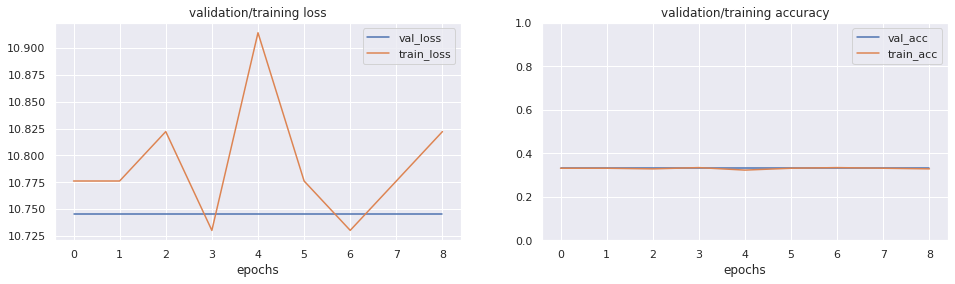

In [27]:
plot_training(history)

# Using pre-trained ResNet3D

In [28]:
!pip install git+https://github.com/JihongJu/keras-resnet3d.git

  Cloning https://github.com/JihongJu/keras-resnet3d.git to /tmp/pip-req-build-w_9khq2n
  Running command git clone -q https://github.com/JihongJu/keras-resnet3d.git /tmp/pip-req-build-w_9khq2n
  Running command git submodule update --init --recursive -q
  Created wheel for keras-resnet3d: filename=keras_resnet3d-0.0.1-cp36-none-any.whl size=4773 sha256=e9740f5667401e8e4b41c2dda9362b445b786559474d305c39baad0c452b053c
  Stored in directory: /tmp/pip-ephem-wheel-cache-01fthe72/wheels/98/fa/00/0dfe23f54c8f40a14c53f355effb4b198f7727d6d7f05be8b1
Successfully built keras-resnet3d


In [0]:
from resnet3d import Resnet3DBuilder

In [32]:
model = Resnet3DBuilder.build_resnet_50(input_shape, 11)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 15, 64, 64, 3 0                                            
__________________________________________________________________________________________________
conv3d_61 (Conv3D)              (None, 8, 32, 32, 64 65920       input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_52 (BatchNo (None, 8, 32, 32, 64 256         conv3d_61[0][0]                  
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 8, 32, 32, 64 0           batch_normalization_52[0][0]     
____________________________________________________________________________________________

In [33]:
# sgd = optimizers.SGD(lr=0.0001)
adam = optimizers.Adam(lr=0.001)

#model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics=['accuracy'])

classweight = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

history = model.fit_generator(train_generator, 
                              steps_per_epoch = (train_generator.files_count // train_generator.batch_size), 
                              epochs = 50, 
                              validation_data = val_generator, 
                              validation_steps = (val_generator.files_count // val_generator.batch_size),
                              class_weight=classweight,
                              verbose = 1, 
                              callbacks=callbacks)

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_24_01.mpg, 1 total, 1 extracted


Epoch 1/50
22/44 [==============>...............] - ETA: 27s - loss: 6.6687 - acc: 0.5114

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_25_06.mpg, 12 total, 12 extracted


32/44 [====================>.........] - ETA: 11s - loss: 6.5500 - acc: 0.5391

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_16_05.mpg, 13 total, 13 extracted


44/44 [==============================] - 36s 811ms/step - loss: 6.3469 - acc: 0.5751 - val_loss: 13.7596 - val_acc: 0.3103


Frame count is not OK for video /tmp/dataset/shooting/v_shooting_24_01.mpg, 1 total, 1 extracted


Epoch 2/50
18/44 [===========>..................] - ETA: 6s - loss: 5.5936 - acc: 0.6528

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_16_05.mpg, 13 total, 13 extracted


29/44 [==================>...........] - ETA: 3s - loss: 5.5147 - acc: 0.6853

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_25_06.mpg, 12 total, 12 extracted


44/44 [==============================] - 11s 241ms/step - loss: 5.4072 - acc: 0.6964 - val_loss: 6.8906 - val_acc: 0.4713


Frame count is not OK for video /tmp/dataset/shooting/v_shooting_24_01.mpg, 1 total, 1 extracted
Frame count is not OK for video /tmp/dataset/shooting/v_shooting_25_06.mpg, 12 total, 12 extracted


Epoch 3/50
27/44 [=================>............] - ETA: 4s - loss: 4.9661 - acc: 0.7910

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_16_05.mpg, 13 total, 13 extracted


44/44 [==============================] - 11s 245ms/step - loss: 4.9298 - acc: 0.7715 - val_loss: 7.8007 - val_acc: 0.3678


Frame count is not OK for video /tmp/dataset/shooting/v_shooting_24_01.mpg, 1 total, 1 extracted


Epoch 4/50
11/44 [======>.......................] - ETA: 8s - loss: 4.6423 - acc: 0.7841

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_16_05.mpg, 13 total, 13 extracted


36/44 [=======================>......] - ETA: 1s - loss: 4.4557 - acc: 0.8264

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_25_06.mpg, 12 total, 12 extracted


44/44 [==============================] - 11s 255ms/step - loss: 4.4427 - acc: 0.8234 - val_loss: 5.9220 - val_acc: 0.5172


Frame count is not OK for video /tmp/dataset/shooting/v_shooting_24_01.mpg, 1 total, 1 extracted


Epoch 5/50


Frame count is not OK for video /tmp/dataset/shooting/v_shooting_16_05.mpg, 13 total, 13 extracted


 8/44 [====>.........................] - ETA: 8s - loss: 4.0786 - acc: 0.8906

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_25_06.mpg, 12 total, 12 extracted


44/44 [==============================] - 11s 254ms/step - loss: 4.1504 - acc: 0.8178 - val_loss: 5.1316 - val_acc: 0.5862


Frame count is not OK for video /tmp/dataset/shooting/v_shooting_24_01.mpg, 1 total, 1 extracted


Epoch 6/50
16/44 [=========>....................] - ETA: 6s - loss: 4.0095 - acc: 0.7812

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_25_06.mpg, 12 total, 12 extracted


25/44 [================>.............] - ETA: 4s - loss: 4.0173 - acc: 0.7686

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_16_05.mpg, 13 total, 13 extracted


44/44 [==============================] - 11s 248ms/step - loss: 3.9545 - acc: 0.7829 - val_loss: 8.7090 - val_acc: 0.4943


Frame count is not OK for video /tmp/dataset/shooting/v_shooting_24_01.mpg, 1 total, 1 extracted


Epoch 7/50
 3/44 [=>............................] - ETA: 9s - loss: 4.1010 - acc: 0.7083

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_25_06.mpg, 12 total, 12 extracted


27/44 [=================>............] - ETA: 4s - loss: 3.6988 - acc: 0.8234

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_16_05.mpg, 13 total, 13 extracted


44/44 [==============================] - 11s 256ms/step - loss: 3.6217 - acc: 0.8219 - val_loss: 5.7230 - val_acc: 0.5057


Frame count is not OK for video /tmp/dataset/shooting/v_shooting_24_01.mpg, 1 total, 1 extracted


Epoch 8/50
15/44 [=========>....................] - ETA: 7s - loss: 3.5221 - acc: 0.7917

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_25_06.mpg, 12 total, 12 extracted


35/44 [======================>.......] - ETA: 2s - loss: 3.4222 - acc: 0.7995

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_16_05.mpg, 13 total, 13 extracted


44/44 [==============================] - 11s 249ms/step - loss: 3.4195 - acc: 0.7890 - val_loss: 4.5352 - val_acc: 0.5862


Frame count is not OK for video /tmp/dataset/shooting/v_shooting_24_01.mpg, 1 total, 1 extracted
Frame count is not OK for video /tmp/dataset/shooting/v_shooting_25_06.mpg, 12 total, 12 extracted


Epoch 9/50
21/44 [=============>................] - ETA: 5s - loss: 3.1795 - acc: 0.8333

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_16_05.mpg, 13 total, 13 extracted


44/44 [==============================] - 11s 250ms/step - loss: 3.2473 - acc: 0.7983 - val_loss: 3.7902 - val_acc: 0.6322


Frame count is not OK for video /tmp/dataset/shooting/v_shooting_24_01.mpg, 1 total, 1 extracted


Epoch 10/50
 4/44 [=>............................] - ETA: 10s - loss: 3.1365 - acc: 0.7188

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_25_06.mpg, 12 total, 12 extracted


10/44 [=====>........................] - ETA: 8s - loss: 2.9762 - acc: 0.8000

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_16_05.mpg, 13 total, 13 extracted


44/44 [==============================] - 11s 252ms/step - loss: 3.0108 - acc: 0.8320 - val_loss: 3.5755 - val_acc: 0.6667


Frame count is not OK for video /tmp/dataset/shooting/v_shooting_24_01.mpg, 1 total, 1 extracted


Epoch 11/50
23/44 [==============>...............] - ETA: 5s - loss: 2.8417 - acc: 0.8261

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_25_06.mpg, 12 total, 12 extracted


25/44 [================>.............] - ETA: 4s - loss: 2.8353 - acc: 0.8300

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_16_05.mpg, 13 total, 13 extracted


44/44 [==============================] - 11s 245ms/step - loss: 2.7787 - acc: 0.8409 - val_loss: 5.8079 - val_acc: 0.3333


Frame count is not OK for video /tmp/dataset/shooting/v_shooting_24_01.mpg, 1 total, 1 extracted


Epoch 12/50
11/44 [======>.......................] - ETA: 8s - loss: 2.5695 - acc: 0.9091

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_25_06.mpg, 12 total, 12 extracted


21/44 [=============>................] - ETA: 5s - loss: 2.6900 - acc: 0.8733

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_16_05.mpg, 13 total, 13 extracted


44/44 [==============================] - 11s 255ms/step - loss: 2.7362 - acc: 0.8166 - val_loss: 2.9962 - val_acc: 0.7356


Frame count is not OK for video /tmp/dataset/shooting/v_shooting_24_01.mpg, 1 total, 1 extracted


Epoch 13/50
22/44 [==============>...............] - ETA: 5s - loss: 2.5706 - acc: 0.8409

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_25_06.mpg, 12 total, 12 extracted


34/44 [======================>.......] - ETA: 2s - loss: 2.4765 - acc: 0.8566

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_16_05.mpg, 13 total, 13 extracted


44/44 [==============================] - 11s 249ms/step - loss: 2.5094 - acc: 0.8405 - val_loss: 3.0653 - val_acc: 0.6207


Frame count is not OK for video /tmp/dataset/shooting/v_shooting_24_01.mpg, 1 total, 1 extracted


Epoch 14/50
11/44 [======>.......................] - ETA: 8s - loss: 2.6397 - acc: 0.7500

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_25_06.mpg, 12 total, 12 extracted


28/44 [==================>...........] - ETA: 3s - loss: 2.5322 - acc: 0.7870

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_16_05.mpg, 13 total, 13 extracted


44/44 [==============================] - 11s 254ms/step - loss: 2.4568 - acc: 0.8247 - val_loss: 2.6504 - val_acc: 0.7816


Frame count is not OK for video /tmp/dataset/shooting/v_shooting_24_01.mpg, 1 total, 1 extracted


Epoch 15/50
 6/44 [===>..........................] - ETA: 10s - loss: 2.2528 - acc: 0.8958

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_25_06.mpg, 12 total, 12 extracted


17/44 [==========>...................] - ETA: 6s - loss: 2.4487 - acc: 0.8277

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_16_05.mpg, 13 total, 13 extracted


43/44 [============================>.] - ETA: 0s - loss: 2.3932 - acc: 0.8177

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_16_05.mpg, 13 total, 13 extracted


44/44 [==============================] - 11s 253ms/step - loss: 2.3878 - acc: 0.8162 - val_loss: 2.3017 - val_acc: 0.8046


Frame count is not OK for video /tmp/dataset/shooting/v_shooting_24_01.mpg, 1 total, 1 extracted


Epoch 16/50
21/44 [=============>................] - ETA: 5s - loss: 2.3086 - acc: 0.8197

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_25_06.mpg, 12 total, 12 extracted


44/44 [==============================] - 11s 246ms/step - loss: 2.2304 - acc: 0.8454 - val_loss: 2.9749 - val_acc: 0.6667


Frame count is not OK for video /tmp/dataset/shooting/v_shooting_24_01.mpg, 1 total, 1 extracted


Epoch 17/50
 6/44 [===>..........................] - ETA: 9s - loss: 1.8886 - acc: 0.9167 

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_25_06.mpg, 12 total, 12 extracted


39/44 [=========================>....] - ETA: 1s - loss: 2.0835 - acc: 0.8356

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_16_05.mpg, 13 total, 13 extracted


44/44 [==============================] - 11s 255ms/step - loss: 2.0669 - acc: 0.8429 - val_loss: 3.3680 - val_acc: 0.4943


Frame count is not OK for video /tmp/dataset/shooting/v_shooting_24_01.mpg, 1 total, 1 extracted


Epoch 18/50
18/44 [===========>..................] - ETA: 6s - loss: 1.8346 - acc: 0.9236

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_16_05.mpg, 13 total, 13 extracted


25/44 [================>.............] - ETA: 4s - loss: 1.8290 - acc: 0.9136

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_25_06.mpg, 12 total, 12 extracted


44/44 [==============================] - 11s 244ms/step - loss: 1.8771 - acc: 0.9054 - val_loss: 2.9810 - val_acc: 0.6667


Frame count is not OK for video /tmp/dataset/shooting/v_shooting_24_01.mpg, 1 total, 1 extracted


Epoch 19/50
 2/44 [>.............................] - ETA: 11s - loss: 1.7454 - acc: 1.0000

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_16_05.mpg, 13 total, 13 extracted


20/44 [============>.................] - ETA: 5s - loss: 1.9821 - acc: 0.8518

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_25_06.mpg, 12 total, 12 extracted


44/44 [==============================] - 11s 251ms/step - loss: 1.9066 - acc: 0.8531 - val_loss: 2.9138 - val_acc: 0.6092


Frame count is not OK for video /tmp/dataset/shooting/v_shooting_24_01.mpg, 1 total, 1 extracted


Epoch 20/50
 9/44 [=====>........................] - ETA: 8s - loss: 1.7838 - acc: 0.9167

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_16_05.mpg, 13 total, 13 extracted


24/44 [===============>..............] - ETA: 4s - loss: 2.0056 - acc: 0.8311

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_25_06.mpg, 12 total, 12 extracted


44/44 [==============================] - 11s 250ms/step - loss: 1.9523 - acc: 0.8300 - val_loss: 2.6063 - val_acc: 0.7471


Frame count is not OK for video /tmp/dataset/shooting/v_shooting_24_01.mpg, 1 total, 1 extracted


Epoch 21/50
 7/44 [===>..........................] - ETA: 9s - loss: 1.7620 - acc: 0.8571

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_16_05.mpg, 13 total, 13 extracted


16/44 [=========>....................] - ETA: 6s - loss: 1.8723 - acc: 0.8516

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_25_06.mpg, 12 total, 12 extracted


44/44 [==============================] - 11s 249ms/step - loss: 1.8381 - acc: 0.8377 - val_loss: 1.8920 - val_acc: 0.8046


Frame count is not OK for video /tmp/dataset/shooting/v_shooting_24_01.mpg, 1 total, 1 extracted


Epoch 22/50
 6/44 [===>..........................] - ETA: 9s - loss: 1.6761 - acc: 0.8333

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_16_05.mpg, 13 total, 13 extracted
Frame count is not OK for video /tmp/dataset/shooting/v_shooting_25_06.mpg, 12 total, 12 extracted


44/44 [==============================] - 11s 251ms/step - loss: 1.6281 - acc: 0.8717 - val_loss: 1.7046 - val_acc: 0.8621


Frame count is not OK for video /tmp/dataset/shooting/v_shooting_24_01.mpg, 1 total, 1 extracted


Epoch 23/50
22/44 [==============>...............] - ETA: 5s - loss: 1.4097 - acc: 0.9602

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_16_05.mpg, 13 total, 13 extracted


29/44 [==================>...........] - ETA: 3s - loss: 1.4050 - acc: 0.9612

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_25_06.mpg, 12 total, 12 extracted


44/44 [==============================] - 11s 248ms/step - loss: 1.5179 - acc: 0.9306 - val_loss: 1.6813 - val_acc: 0.8276


Frame count is not OK for video /tmp/dataset/shooting/v_shooting_24_01.mpg, 1 total, 1 extracted


Epoch 24/50
 5/44 [==>...........................] - ETA: 9s - loss: 1.4421 - acc: 0.9000 

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_25_06.mpg, 12 total, 12 extracted


27/44 [=================>............] - ETA: 4s - loss: 1.5728 - acc: 0.8796

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_16_05.mpg, 13 total, 13 extracted


44/44 [==============================] - 11s 251ms/step - loss: 1.6427 - acc: 0.8377 - val_loss: 2.5080 - val_acc: 0.6782


Frame count is not OK for video /tmp/dataset/shooting/v_shooting_24_01.mpg, 1 total, 1 extracted


Epoch 25/50
12/44 [=======>......................] - ETA: 7s - loss: 1.5901 - acc: 0.8750

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_16_05.mpg, 13 total, 13 extracted


15/44 [=========>....................] - ETA: 7s - loss: 1.5402 - acc: 0.8905

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_25_06.mpg, 12 total, 12 extracted


44/44 [==============================] - 11s 250ms/step - loss: 1.5270 - acc: 0.8770 - val_loss: 3.5787 - val_acc: 0.6207


Frame count is not OK for video /tmp/dataset/shooting/v_shooting_24_01.mpg, 1 total, 1 extracted


Epoch 26/50
12/44 [=======>......................] - ETA: 7s - loss: 1.4094 - acc: 0.9062

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_16_05.mpg, 13 total, 13 extracted


19/44 [===========>..................] - ETA: 6s - loss: 1.4159 - acc: 0.9135

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_25_06.mpg, 12 total, 12 extracted


44/44 [==============================] - 11s 249ms/step - loss: 1.3897 - acc: 0.9249 - val_loss: 1.7616 - val_acc: 0.7471


Frame count is not OK for video /tmp/dataset/shooting/v_shooting_24_01.mpg, 1 total, 1 extracted


Epoch 27/50
24/44 [===============>..............] - ETA: 4s - loss: 1.4092 - acc: 0.8802

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_16_05.mpg, 13 total, 13 extracted


27/44 [=================>............] - ETA: 4s - loss: 1.4354 - acc: 0.8704

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_25_06.mpg, 12 total, 12 extracted


44/44 [==============================] - 11s 249ms/step - loss: 1.3992 - acc: 0.8738 - val_loss: 1.7144 - val_acc: 0.8046


Frame count is not OK for video /tmp/dataset/shooting/v_shooting_24_01.mpg, 1 total, 1 extracted


Epoch 28/50
20/44 [============>.................] - ETA: 5s - loss: 1.3068 - acc: 0.9250

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_25_06.mpg, 12 total, 12 extracted


35/44 [======================>.......] - ETA: 2s - loss: 1.3039 - acc: 0.9092

Frame count is not OK for video /tmp/dataset/shooting/v_shooting_16_05.mpg, 13 total, 13 extracted


44/44 [==============================] - 11s 240ms/step - loss: 1.3541 - acc: 0.8848 - val_loss: 4.3225 - val_acc: 0.4598
Epoch 00028: early stopping


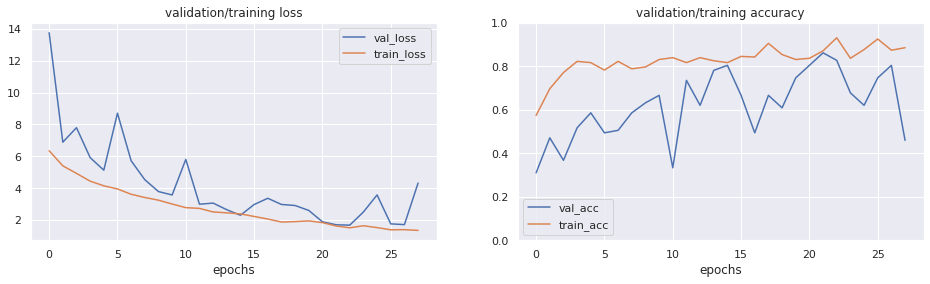

In [34]:
plot_training(history)

# 3DCNN with extracting frames as array

In [0]:
# image specification
n_frames = 15
img_rows,img_cols,img_depth=16,16,n_frames
# Training data
X_tr=[]           # variable to store entire dataset
label=[]

In [0]:
path = '/tmp/dataset_11/'

folders = os.listdir(path)
vid_class = -1
for folder in folders:
  vid_class += 1  
  folder_path = os.path.join(path,folder)
  listing = os.listdir(folder_path)
  for vid in listing:
    vid = os.path.join(path,folder,vid)
    frames = []
    cap = cv2.VideoCapture(vid)
    fps = cap.get(5) 

    for k in range(n_frames):
        ret, frame = cap.read()
        if np.shape(frame) != ():
          frame=cv2.resize(frame,(img_rows,img_cols),interpolation=cv2.INTER_AREA)
          gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
          frames.append(gray) 

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

    input=np.array(frames)

    #print input.shape
    ipt=np.rollaxis(np.rollaxis(input,2,0),2,0)    

    if(ipt.shape[2] == n_frames):
       X_tr.append(ipt)
       label.append(vid_class)       

In [44]:
np.shape(X_tr)

(1597, 16, 16, 15)

In [45]:
np.shape(label)

(1597,)

In [46]:
X_tr_array = np.array(X_tr)   # convert the frames read into array

num_samples = len(X_tr_array)
print(num_samples)

train_data = [X_tr_array,label]

(X_train, y_train) = (train_data[0],train_data[1])
print('X_Train shape:', X_train.shape)

train_set = np.zeros((num_samples, 1, img_rows,img_cols,img_depth))

for h in range(num_samples):
    train_set[h][0][:][:][:]=X_train[h,:,:,:]


patch_size = 15    # img_depth or number of frames used for each video

print(train_set.shape, 'train samples')

# CNN Training parameters

batch_size = 2
nb_classes = 11
nb_epoch = 50

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)

# number of convolutional filters to use at each layer
nb_filters = [  32,   # 1st conv layer
                32    # 2nd
             ]

# level of pooling to perform at each layer (POOL x POOL)
nb_pool = [3, 3]

# level of convolution to perform at each layer (CONV x CONV)
nb_conv = [5,5]

# Pre-processing
train_set = train_set.astype('float32')
train_set -= np.mean(train_set)
train_set /= np.max(train_set)

# Split the data
X_train_new, X_val_new, y_train_new,y_val_new = train_test_split(train_set, Y_train, test_size=0.1, random_state=4)

1597
X_Train shape: (1597, 16, 16, 15)
(1597, 1, 16, 16, 15) train samples


In [47]:
# Define model

model = Sequential()
model.add(Conv3D(32,(5,5,5),data_format = 'channels_first',input_shape=(1,img_rows, img_cols, patch_size),activation='relu'))
model.add(MaxPool3D())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, init='normal', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes,init='normal'))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

model.summary()

# Train the model
history = model.fit(
    X_train_new,
    y_train_new,
    validation_data=(X_val_new,y_val_new),
    batch_size=batch_size,
    nb_epoch = nb_epoch,
    shuffle=True
    )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, activation="relu", kernel_initializer="normal")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(11, kernel_initializer="normal")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_115 (Conv3D)          (None, 32, 12, 12, 11)    4032      
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 16, 6, 6, 11)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 6, 6, 11)      0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 6336)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               811136    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 11)               

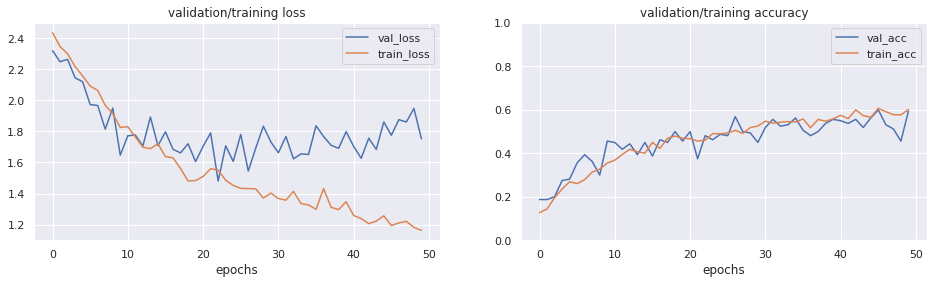

In [48]:
plot_training(history)